In [557]:
import pandas as pd
import numpy as np
import re # not really used atm
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [558]:
from sklearn.preprocessing import StandardScaler # to scale data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

# NN model
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import SGD #test keras


In [559]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [560]:
def check_null(df):
    print('\ncheck null values \n')
    print('shape df: ', df.shape, '\n')
    ok_columns = [col for col in df if df[col].isna().sum() == 0]
    print('ok columns: ', ok_columns, '\n')
    for col in df:
        if df[col].isna().sum() >0:
            print(col, ':', df[col].isna().sum())

In [561]:
df_original = pd.read_csv('../input/output_print_1683.csv')

In [562]:
# remove rows with NaN (originating e.g. from empty lines in input file)
df_original = df_original[df_original['flav'].notna()] 

In [563]:
# check_null(df)

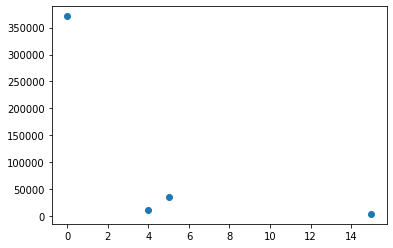

In [564]:
plt.scatter(df_original['flav'].value_counts().index, df_original['flav'].value_counts())

In [565]:
# do not consider PU jets
df = df_original[(df_original['truth_match']>0) & (df_original['quark_match']>0)]
#df = df_original[(df_original['ele_match']<1)]
# for the moment I want to focus on b-vs-light --> keep only real light and b, and put target to flav=5
df = df[(df['flav']==0) | (df['flav']==5) ]
df['target'] = (df['flav'] == 5 ).astype(int)

In [566]:
df[['truth_match','quark_match','ele_match']].describe()

,truth_match,quark_match,ele_match
count,94128.0,94128.0,94128.000000
mean,1.0,1.0,0.058272
std,0.0,0.0,0.234258
min,1.0,1.0,0.000000
25%,1.0,1.0,0.000000
50%,1.0,1.0,0.000000
75%,1.0,1.0,0.000000
max,1.0,1.0,1.000000


In [567]:
# check how many events and the fraction of b-jets
df['target'].describe()

count    94128.000000
mean     0.348122    
std      0.476377    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      1.000000    
max      1.000000    
Name: target, dtype: float64

In [568]:
df = df.replace([-999],[0])

In [569]:
# change the track pT into fraction of the jet_pt
# change time into time-t0 (if no t0, t0 is set to zero so no difference)
for i in range(25):
    col = 'pt_trk'+'_'+str(i)
    df[col] = df[col]/df['jet_pt']
    col = 'time_truth'+'_'+str(i)
    df[col] = df[col]-df['t0']

In [570]:
df['avg_trk_time'] = 0
df.loc[df['n_trk']>0,'avg_trk_time'] = (sum(df['time_truth'+'_'+str(i)] for i in range(25)))/df['n_trk']

In [571]:
for i in range(25):
    df.loc[df['has_t0']<1,'time'+'_'+str(i)] = df['time_truth'+'_'+str(i)] - df['avg_trk_time']

In [572]:
check_null(df)


check null values 

shape df:  (94128, 362) 

ok columns:  ['name', 'flav', 'truth_match', 'quark_match', 'ele_match', 'jet_pt', 'jet_eta', 'n_trk', 'ValZ0_0', 'SigZ0_0', 'ValD0_0', 'SigZ0_0.1', 'IP3D_trk_pb_0', 'IP3D_trk_pu_0', 'IP3D_trk_pc_0', 'pt_trk_0', 'has_time_0', 'time_0', 'nhits_0', 'has_time_truth_0', 'time_truth_0', 'nhits_truth_0', 'ValZ0_1', 'SigZ0_1', 'ValD0_1', 'SigZ0_1.1', 'IP3D_trk_pb_1', 'IP3D_trk_pu_1', 'IP3D_trk_pc_1', 'pt_trk_1', 'has_time_1', 'time_1', 'nhits_1', 'has_time_truth_1', 'time_truth_1', 'nhits_truth_1', 'ValZ0_2', 'SigZ0_2', 'ValD0_2', 'SigZ0_2.1', 'IP3D_trk_pb_2', 'IP3D_trk_pu_2', 'IP3D_trk_pc_2', 'pt_trk_2', 'has_time_2', 'time_2', 'nhits_2', 'has_time_truth_2', 'time_truth_2', 'nhits_truth_2', 'ValZ0_3', 'SigZ0_3', 'ValD0_3', 'SigZ0_3.1', 'IP3D_trk_pb_3', 'IP3D_trk_pu_3', 'IP3D_trk_pc_3', 'pt_trk_3', 'has_time_3', 'time_3', 'nhits_3', 'has_time_truth_3', 'time_truth_3', 'nhits_truth_3', 'ValZ0_4', 'SigZ0_4', 'ValD0_4', 'SigZ0_4.1', 'IP3D_trk_pb_4',

In [573]:
df[['flav']+['pt_trk'+'_'+str(i) for i in range(9)]].head()
# pfff, these are not pt ordered :( Probably pt-ordeered before calibration

,flav,pt_trk_0,pt_trk_1,pt_trk_2,pt_trk_3,pt_trk_4,pt_trk_5,pt_trk_6,pt_trk_7,pt_trk_8
3,5.0,0.084658,0.066121,0.058145,0.048145,0.043123,0.029888,0.025749,0.027303,0.023860
4,0.0,0.099132,0.170848,0.093001,0.028576,0.059057,0.038806,0.000000,0.000000,0.000000
11,0.0,0.308656,0.476114,0.224626,0.016242,0.009425,0.009914,0.000000,0.000000,0.000000
12,0.0,0.196172,0.053959,0.029415,0.677865,0.046929,0.029570,0.024180,0.024415,0.029972
13,5.0,0.030414,0.063343,0.029997,0.452264,0.032486,0.029558,0.106201,0.000000,0.000000


In [574]:
# useful to make list of column names
trk_info = ["ValZ0","SigZ0","ValD0","SigZ0","IP3D_trk_pb","IP3D_trk_pu","IP3D_trk_pc","pt_trk","has_time","time","nhits","has_time_truth","time_truth","nhits_truth"]

string=''
for i in range(25):
    for info in trk_info:
        string+=info+'_'+str(i)+', '

# print(string)

In [575]:
columns_to_use = []
trk_info_to_keep = ["IP3D_trk_pb","IP3D_trk_pu", "has_time_truth","time_truth","nhits"]
for i in range(20):
    for info in trk_info_to_keep:
        columns_to_use.append(info+'_'+str(i))

In [576]:
columns_to_use_df = columns_to_use[:]
columns_to_use_df += ['target','has_t0','t0']
df_to_use = df[columns_to_use_df]

In [577]:
#columns_to_use.remove('target')
# columns_to_use

In [578]:
# convert df into arrays
X = df_to_use[columns_to_use+['has_t0','t0']].values
y = df_to_use['target'].values
# scaling
sc = StandardScaler()
X = sc.fit_transform(X) 

In [579]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [580]:
# Neural network
model = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model.add(Dense(300, input_dim=len(columns_to_use)+2, activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
# loss function and optimizer
#opt = SGD(lr=0.001)
#model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model.fit(X_train, y_train, epochs=10, batch_size=50, # it was 100 epochs
                    validation_data = (X_test,y_test)) # show accuracy on test data after every epoch

Train on 65889 samples, validate on 28239 samples
Epoch 1/10
65889/65889 [==============================] - 6s 86us/step - loss: 0.3265 - acc: 0.8704 - val_loss: 0.3292 - val_acc: 0.8663
Epoch 2/10
65889/65889 [==============================] - 6s 85us/step - loss: 0.3099 - acc: 0.8772 - val_loss: 0.3238 - val_acc: 0.8659
Epoch 3/10
65889/65889 [==============================] - 6s 90us/step - loss: 0.3057 - acc: 0.8792 - val_loss: 0.3283 - val_acc: 0.8645
Epoch 4/10
65889/65889 [==============================] - 5s 83us/step - loss: 0.3031 - acc: 0.8792 - val_loss: 0.3177 - val_acc: 0.8706
Epoch 5/10
65889/65889 [==============================] - 6s 86us/step - loss: 0.2994 - acc: 0.8811 - val_loss: 0.3172 - val_acc: 0.8713
Epoch 6/10
65889/65889 [==============================] - 6s 88us/step - loss: 0.2982 - acc: 0.8826 - val_loss: 0.3241 - val_acc: 0.8669
Epoch 7/10
65889/65889 [==============================] - 6s 88us/step - loss: 0.2953 - acc: 0.8827 - val_loss: 0.3219 - val_acc

In [581]:
# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


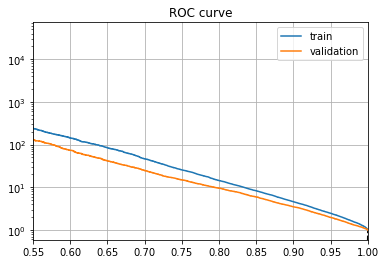

In [582]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, 1./fpr_test, label='validation')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.yscale('log')
plt.xlim(0.55,1)
plt.grid(True)
plt.show()

In [583]:
X_train

array([[ 1.11384417e-01,  2.05590046e-01,  5.50953191e-01, ...,
        -2.82386744e-02,  1.48198665e+00,  3.20271058e-01],
       [-1.28253530e-01, -2.25705350e-01, -1.81503622e+00, ...,
        -2.82386744e-02, -9.79635581e-01, -1.10544094e-04],
       [-9.56990822e-02,  6.17534720e-02,  5.50953191e-01, ...,
        -2.82386744e-02, -9.79635581e-01, -1.10544094e-04],
       ...,
       [ 3.37030320e-01, -1.05097166e+00,  5.50953191e-01, ...,
        -2.82386744e-02,  1.48198665e+00,  4.93742974e-01],
       [ 3.19213454e-02, -1.14541587e-01,  5.50953191e-01, ...,
        -2.82386744e-02, -9.79635581e-01, -1.10544094e-04],
       [-2.19317323e-01,  4.79810406e-02,  5.50953191e-01, ...,
        -2.82386744e-02, -9.79635581e-01, -1.10544094e-04]])

In [584]:
type(X_train)

numpy.ndarray

In [585]:
X_train.shape

(65889, 102)

In [586]:
test = range(45)

In [587]:
test2 = [i for i in test if i % 5 < 2]

In [588]:
X_train_no_HGTD = X_train[:,test2]
X_test_no_HGTD = X_test[:,test2]

In [589]:
X_train_no_HGTD.shape

(65889, 18)

In [590]:
# Neural network
model2 = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model2.add(Dense(300, input_dim=len(test2), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model2.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model2.fit(X_train_no_HGTD, y_train, epochs=10, batch_size=50, # it was 100 epochs
                    validation_data = (X_test_no_HGTD,y_test)) # show accuracy on test data after every epoch

Train on 65889 samples, validate on 28239 samples
Epoch 1/10
65889/65889 [==============================] - 5s 75us/step - loss: 0.3312 - acc: 0.8682 - val_loss: 0.3313 - val_acc: 0.8649
Epoch 2/10
65889/65889 [==============================] - 5s 69us/step - loss: 0.3240 - acc: 0.8711 - val_loss: 0.3310 - val_acc: 0.8663
Epoch 3/10
65889/65889 [==============================] - 5s 70us/step - loss: 0.3222 - acc: 0.8718 - val_loss: 0.3331 - val_acc: 0.8665
Epoch 4/10
65889/65889 [==============================] - 5s 71us/step - loss: 0.3215 - acc: 0.8719 - val_loss: 0.3290 - val_acc: 0.8668
Epoch 5/10
65889/65889 [==============================] - 5s 72us/step - loss: 0.3212 - acc: 0.8729 - val_loss: 0.3320 - val_acc: 0.8651
Epoch 6/10
65889/65889 [==============================] - 5s 69us/step - loss: 0.3204 - acc: 0.8730 - val_loss: 0.3319 - val_acc: 0.8652
Epoch 7/10
65889/65889 [==============================] - 4s 67us/step - loss: 0.3202 - acc: 0.8727 - val_loss: 0.3306 - val_acc

In [591]:
# Prediction
y_pred_test_no_HGTD = model2.predict(X_test_no_HGTD)
y_pred_train_no_HGTD = model2.predict(X_train_no_HGTD)

fpr_test_no_HGTD, tpr_test_no_HGTD, thresholds_test_no_HGTD = roc_curve(y_test, y_pred_test_no_HGTD)
fpr_train_no_HGTD, tpr_train_no_HGTD, thresholds_train_no_HGTD = roc_curve(y_train, y_pred_train_no_HGTD)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


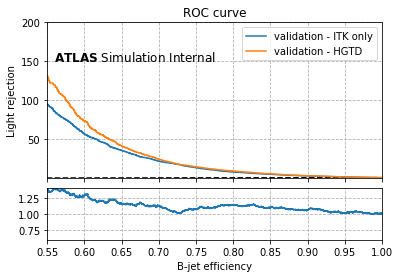

In [595]:
gs = gridspec.GridSpec(2, 1,
                       height_ratios=[3,1],
                       hspace=0.10)
ax1 = plt.subplot(gs[0])

plt.figure(1)
plt.text(0.02, 0.75, r'$\mathbf{ATLAS}$ Simulation Internal', size='large',transform=ax1.transAxes)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(tpr_train_no_HGTD, 1./fpr_train_no_HGTD, label='train_no_HGTD')
one_over_fpr_test_no_HGTD = 1./fpr_test_no_HGTD
one_over_fpr_test = 1./fpr_test
plt.plot(tpr_test_no_HGTD, one_over_fpr_test_no_HGTD, label='validation - ITK only')
#plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, one_over_fpr_test, label='validation - HGTD')
plt.ylabel('Light rejection')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.yscale('log')
plt.xlim(0.55,1)
plt.ylim(1,200)
plt.grid(True,linestyle='--')
plt.gca().set_xticklabels(['']*10)

ax2 = plt.subplot(gs[1])
plt.xlim(0.55,1)
plt.ylim(0.6,1.4)
#np.interp([0, 1, 1.5, 2.72, 3.14], xp, fp)
one_over_fpr_test_plot = np.interp(tpr_test_no_HGTD, tpr_test, one_over_fpr_test)
ljr_ratio = np.divide(one_over_fpr_test_plot, one_over_fpr_test_no_HGTD)
plt.plot(tpr_test_no_HGTD, ljr_ratio)
plt.grid(True,linestyle='--')
plt.xlabel('B-jet efficiency')

plt.show()